<a href="https://colab.research.google.com/github/armandossrecife/piloto/blob/main/satd_analyzer_with_critical_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Passos do experimento SATD em commits, issues com Classes Críticas (by ATDCodeAnalyzer)

Análise de SATD das mensagens e diffs de commits, bem como análise dos conteúdos de summary, description e comments de issues registrados em commits

1. Definir o conjunto de keywords da literatura

2. Fazer a análise de keywords para as mensagens dos commits e os diffs dos commits

2.1 Filtrar apenas os commits que possuam as classes críticas (by ATDCodeAnalyzer)

2.1.1 Gerar uma planilha correspondente e fazer a análise manual dos commits com suspeita de SATD

3. Fazer a análise de keywords para os issues que são registrados nos commits para os summary, description e comments

3.1 Filtrar apenas os issues com commits que possuam as classes críticas (by ATDCodeAnalyzer)

3.1.1 Gerar uma planilha correspondente e fazer a análise manual dos issues com suspeita de SATD

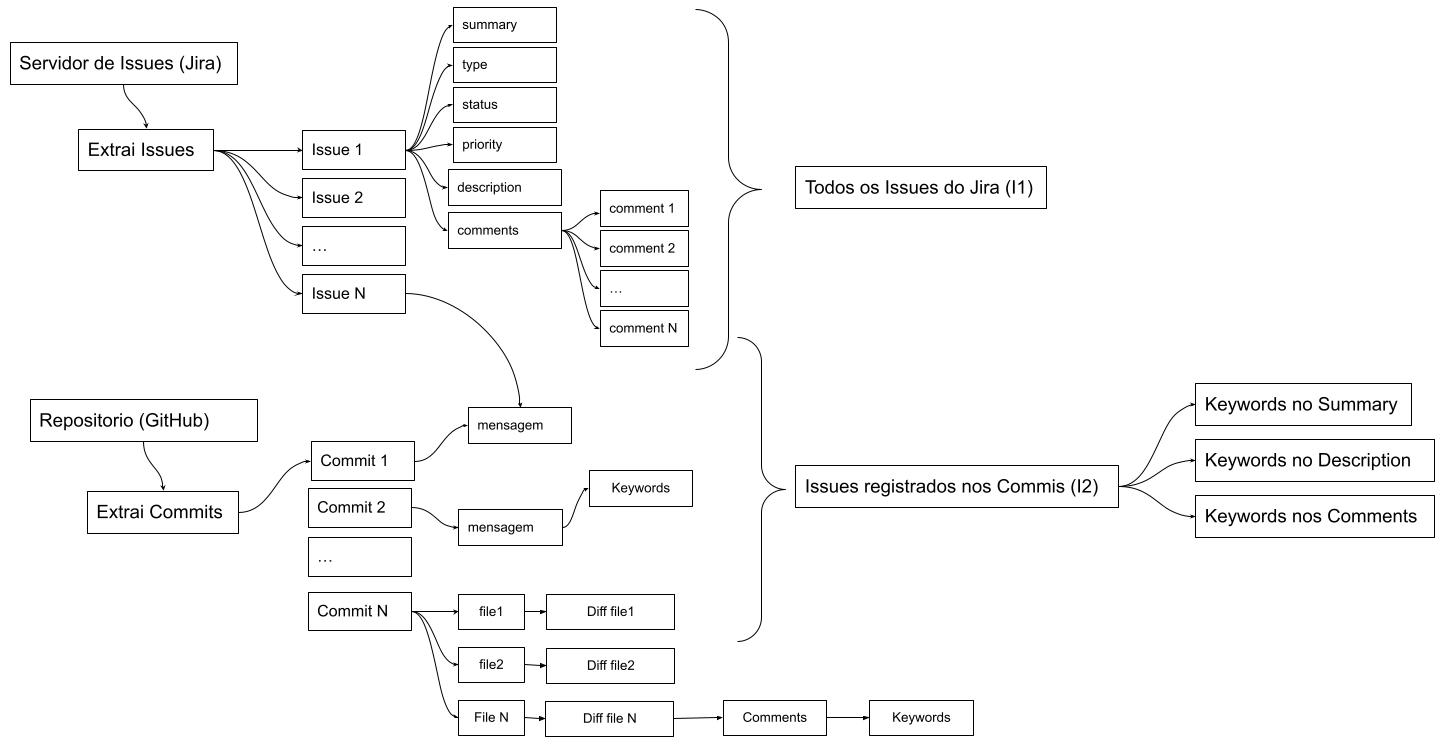

# My SATD Analyzer

1. Identify Keywords for Self-Admitted Technical Debt (SATD):
Start by identifying keywords or phrases that commonly indicate self-admitted technical debt. These keywords can be derived from literature or based on your understanding of common terms used in code comments, commit messages, and issue descriptions. For example, common keywords may include "TODO," "FIXME," "refactor," "technical debt," "hack," "workaround," etc.

2. Create a Dictionary of SATD Keywords:
Build a dictionary or a set of SATD keywords that will serve as the basis for content queries in commit messages, modified file comments, and issue descriptions. This dictionary should include the keywords identified in Step 1.

3. Using PyDriller for Commit Analysis:
You can use PyDriller to analyze commits from the repository. PyDriller is a Python library for analyzing Git repositories. Install it using pip.
Create Python scripts that use PyDriller to iterate through the commits and identify those that contain SATD keywords in their messages. You can filter commits based on these keywords and store them in a Set.

4. Analyze Modified Files in Commits:
For each commit, extract the list of modified files. Open and analyze these files to check for SATD keywords in the code comments within the modified lines. Store the commits with modified files containing SATD in a separate Set.

5. Retrieve Issues from the Issue Tracker:
Utilize an API or libraries like JIRA's REST API to fetch issues from the issue tracker (JIRA in this case). For example, you can use Python's requests library to interact with the JIRA API. Query issues based on project (e.g., CASSANDRA) and extract the content of the Summary, Description, and Comments fields for each issue.

6. Analyze Issue Descriptions and Comments:
Analyze the content of the Summary, Description, and Comments fields for the presence of SATD keywords. Store the issues that contain these keywords in a Set.

7. Combine Results:
Combine the sets of commits and issues identified with SATD keywords from Steps 3, 4, and 6.

8. Display or Save Results:
You can choose to display the list of commits and issues with SATD keywords or save this information to a file or a database for further analysis.

9. Additional Preprocessing:
Depending on the quality of your results, you may need to perform additional preprocessing, such as removing false positives or refining the set of SATD keywords.



# 1. Install the dependencies

- Pydriller
- GitPython
- JiraPython
- SQLite

In [1]:
print('Install Pydriller.')
!pip install pydriller > install_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('Install SQLite in Linux')
!sudo apt install -y sqlite3 > install_sqlite.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install Pydriller.
Install gitpython.
Install Jira Python lib.
Install SQLite in Linux


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
All depenpencies installed!
Details in install.log


# 2. Import dependencies, configurations and supporting classes

In [110]:
from pydriller import Repository
import tqdm
import os
import re

from jira import JIRA
from datetime import datetime, timedelta
import sqlite3
import subprocess

import collections
import pandas as pd
import matplotlib.pyplot as plt

In [111]:
url_to_repository = 'https://github.com/apache/cassandra.git'
path_to_repository = 'cassandra'
os.environ['MY_REPOSITORY'] = url_to_repository

JIRA_SERVER = 'https://issues.apache.org/jira'
DATABASE_NAME = "issues_db.db"

os.environ['DATABASE_NAME'] = DATABASE_NAME
# Credentials
os.environ['USERNAME'] = 'armandossrecife'
os.environ['PASSWORD'] = 'sky1979#ce'
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')

In [112]:
class SATDCommitAnalyzer:
    def __init__(self, path_to_repository):
        self.path_to_repository = path_to_repository

    @staticmethod
    def is_java_comment(line):
        """Checks if a line is a single-line Java comment.

        Args:
          line: The line to check.

        Returns:
          True if the line is a single-line Java comment, False otherwise.
        """

        # Regular expression pattern to match Java comments
        comment_pattern = r'^\s*//|^\s*/\*|^\s*\*|^\s*\*/'

        # Use the re.match function to check if the line matches the comment pattern
        return bool(re.match(comment_pattern, line))

    def analyze_commits_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for SATD by checking if the commit message contains any of the specified SATD keywords.

        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.

        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress messagem commit analysis"):
            for keyword in satd_keywords:
                if keyword in commit.msg:
                    commits_with_satd.add(commit.hash)
                    dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commit_diffs_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.

        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.

        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress diff commit analysis"):
            list_keywords_by_commit = []
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]

                    for keyword in satd_keywords:
                        if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                            if keyword in conteudo_linha:
                                list_keywords_by_commit.append(keyword)
                                list_diff_content_by_commit.append(conteudo_linha)

            if list_keywords_by_commit:
                elemento = list_keywords_by_commit, list_diff_content_by_commit
                dict_commit_diffs[commit.hash] = elemento

        return dict_commit_diffs

In [113]:
def get_commits_by_range_and_critical_files(initial_date, final_date, critical_files):
  """Extracts information from a date range of commits, focusing on critical files.
  Args:
      initial_date: inicial date of commits tuple (year, month, day) ex: (2001,12,01)
      final_date: final date of commits tuple (year, month, day) ex: (2023,12,31)
      critical_files: A list of critical file paths. ex: ['StorageService.java', 'ColumnFamilyStore.java']
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, a list of critical files modified in the commit, a dictionary of diff [filename]:filename.diff, a list_of_modified_files, a list of all diffs from modified files
  """

  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository("cassandra", since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository("cassandra", since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress critical files commit anlysis"):
      list_of_critical_files_modified = []
      list_of_modified_files = []
      list_dict_of_diff_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_diff_file = {}
        list_of_modified_files.append(m.filename)
        list_dict_of_diff_modified_files.append(m.diff)
        if m.filename in critical_files:
          list_of_critical_files_modified.append(m.filename)
          dict_diff_file[m.filename] = m.diff
          list_dict_of_diff_files.append(dict_diff_file)
      if len(list_of_critical_files_modified) > 0:
        data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
        element = commit.msg, list_of_critical_files_modified, data_commit, commit.lines, commit.files, list_dict_of_diff_files, list_of_modified_files, list_dict_of_diff_modified_files
        dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits


In [114]:
class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments

  def get_comments(self) -> dict:
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

class IssuesDatabase:
    def __init__(self, database_name):
        self.database_name = database_name
        self.create_tables()

    def create_tables(self):
        self.conn = sqlite3.connect(self.database_name)
        self.cursor = self.conn.cursor()

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Issues (
                id INTEGER PRIMARY KEY,
                project TEXT,
                key TEXT,
                summary TEXT,
                issue_type TEXT,
                status TEXT,
                priority TEXT,
                description TEXT
            )
        ''')

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Comments (
                id INTEGER PRIMARY KEY,
                key TEXT,
                comment TEXT
            )
        ''')

        self.conn.commit()

    def insert_in_table_issues(self, project, key, summary, issue_type, status, priority, description):
        values = (None, project, key, summary, issue_type, status, priority, description)
        self.cursor.execute('''
            INSERT INTO Issues
            (id, project, key, summary, issue_type, status, priority, description)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', values)

        self.conn.commit()

    def insert_in_table_comments(self, key, comment):
        values = (None, key, comment)
        self.cursor.execute('''
            INSERT INTO Comments
            (id, key, comment)
            VALUES (?, ?, ?)
        ''', values)

        self.conn.commit()

    def show_content(self, table):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()
        for row in rows:
            print(row)

    def show_n_lines(self, table, n):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            print(row)
            if i == n:
              break

    def close_connection(self):
        self.conn.close()

def analyze_jira_issues_for_satd(project, satd_keywords, all_issues):
    # Create an instance of JiraIssues to manage SATD issues
    satd_issues = JiraIssues(project, [])

    total_items = len(all_issues)

    # Iterate through the fetched issues
    for issue in tqdm.tqdm(all_issues, total=total_items, desc='Progress jira issues analysis'):
        issue_key = issue.key
        issue_summary = issue.fields.summary
        issue_description = issue.fields.description
        issue_comments = [comment.body for comment in issue.fields.comment.comments]

        # Check for SATD keywords in the issue's summary, description, and comments
        if issue_summary is None:
            issue_summary = ""
        if issue_description is None:
            issue_description = ""
        if issue_comments is None:
            issue_comments = ""

        is_satd = any(keyword in (issue_summary + issue_description + ' '.join(issue_comments)) for keyword in satd_keywords)

        if is_satd:
            issue_type = issue.fields.issuetype.name
            issue_status = issue.fields.status.name
            issue_priority = issue.fields.priority.name

            # Create a JiraIssue instance for the SATD issue
            satd_issue = JiraIssue(issue_key, issue_summary, issue_type, issue_status, issue_priority, issue_description, issue_comments)

            # Add the SATD issue to the list of SATD issues
            satd_issues.add_issue(satd_issue)

    return satd_issues


# 3. Cloning the local repository

In [6]:
print(f'Clona o repositório : {url_to_repository}')
!git clone $MY_REPOSITORY

Clona o repositório : https://github.com/apache/cassandra.git
Cloning into 'cassandra'...
remote: Enumerating objects: 403125, done.
remote: Counting objects: 100% (5904/5904), done.
remote: Compressing objects: 100% (2082/2082), done.
remote: Total 403125 (delta 2845), reused 5524 (delta 2745), pack-reused 397221
Receiving objects: 100% (403125/403125), 399.26 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (234759/234759), done.


In [12]:
!cd cassandra && git log --pretty="%H %s" > all_commits_msg.txt
!cd cassandra && git log --pretty="%H;%ai;%s" > all_commits_full.txt

In [14]:
# Dados do 1o commit e do ultimo commit
!echo "Último commit: "
!head /content/cassandra/all_commits_full.txt -n 1
!echo "Primeiro commit: "
!tail /content/cassandra/all_commits_full.txt -n 1

Último commit: 
a1de444331f94f34ceb653f7881e31a00d7511f7;2023-10-04 13:53:04 +0200;Merge branch 'cassandra-5.0' into trunk
Primeiro commit: 
1f91e99223b0d1b7ed8390400d4a06ac08e4aa85;2009-03-02 07:57:22 +0000;git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@749218 13f79535-47bb-0310-9956-ffa450edef68


# 4. Keywords about SATD

[1] Rantala, Leevi, and Mika Mäntylä. "Predicting technical debt from commit contents: reproduction and extension with automated feature selection." Software Quality Journal 28 (2020): 1551-1579. ~> https://link.springer.com/article/10.1007/s11219-020-09520-3

[2] Li, Yikun, Mohamed Soliman, and Paris Avgeriou. "Automatic identification of self-admitted technical debt from four different sources." Empirical Software Engineering 28, no. 3 (2023): 1-38. ~> https://link.springer.com/article/10.1007/s10664-023-10297-9

[3] Potdar, Aniket, and Emad Shihab. "An exploratory study on self-admitted technical debt." In 2014 IEEE International Conference on Software Maintenance and Evolution, pp. 91-100. IEEE, 2014. ~> https://ieeexplore.ieee.org/abstract/document/6976075

In [78]:
satd_keywords = {
    "typo", "unused import", "error message", "comment", "logging", "javadoc", "minor", "update",
    "debug", "code cleanup", "formatting", "more tests", "documentation", "work in progress",
    "improvement", "rename", "support for", "header", "interface", "annotation", "naming",
    "tidy up", "files", "extension point", "exception", "handling", "test", "output", "cast",
    "simplify", "findbugs", "leak", "implementation", "unused code", "API", "refactoring",
    "checkstyle errors", "redundant", "deprecated code", "constructor", "endpoints", "flaky",
    "unused", "unnecessary", "confusing", "ugly", "simplify", "too much", "not used", "more readable",
    "more efficient", "dead code", "infinite loop", "too long", "not implemented", "less verbose",
    "more robust", "speed up", "get rid of", "not thread safe", "clean up code", "not done yet",
    "avoid extra seek", "reduce duplicate code", "no longer needed", "not supported yet",
    "documentation doesn't match", "short term solution", "spurious error messages", "it'd be nice",
    "please add a test", "would significantly improve", "performance", "makes it much easier",
    "avoid calling it twice", "takes a long time", "good to have coverage",
    "makes it very hard", "patch doesn't apply cleanly", "it's not perfectly documented",
    "need to update documentation", "make it less brittle", "documentation does not mention",
    "wastes a lot of space", "there is no unit test", "lead to huge memory allocation",
    "test doesn't add much value", "some holes in the doc", "by hard coding instead of",
    "should be updated to reflect", "more tightly coupled than ideal", "any chance of a test",
    "should improve a bit by", "solution won't be really satisfactory", "misleading",
    "too long", "please add a test", "there is no unit test", "any chance of a test",
    "good to have coverage", "test doesn't add much value", "flaky",
}

satd_keywords_diff = {'TODO', 'FIXME', 'refactor', 'refact', 'hack', 'workaround', 'technical debt', 'cleanup', 'clean', 'fix'}

my_satd_keywords = satd_keywords_diff.union(satd_keywords)

# Sort the set of strings in ascending order.
sorted_my_satd_keywords = sorted(my_satd_keywords)

# Print the sorted set of strings.
for keyword in sorted_my_satd_keywords:
  print(keyword)

API
FIXME
TODO
annotation
any chance of a test
avoid calling it twice
avoid extra seek
by hard coding instead of
cast
checkstyle errors
clean
clean up code
cleanup
code cleanup
comment
confusing
constructor
dead code
debug
deprecated code
documentation
documentation does not mention
documentation doesn't match
endpoints
error message
exception
extension point
files
findbugs
fix
flaky
formatting
get rid of
good to have coverage
hack
handling
header
implementation
improvement
infinite loop
interface
it'd be nice
it's not perfectly documented
javadoc
lead to huge memory allocation
leak
less verbose
logging
make it less brittle
makes it much easier
makes it very hard
minor
misleading
more efficient
more readable
more robust
more tests
more tightly coupled than ideal
naming
need to update documentation
no longer needed
not done yet
not implemented
not supported yet
not thread safe
not used
output
patch doesn't apply cleanly
performance
please add a test
reduce duplicate code
redundant
refac

# 5. Analyze commits

Analisa todas as mensagens dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as Keywords coletadas da literatura.

In [79]:
start_date = datetime(2009, 3, 2, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)

my_satd_commit_analyzer = SATDCommitAnalyzer(path_to_repository)
commits_with_satd, dict_commit_msg = my_satd_commit_analyzer.analyze_commits_for_satd(start_date, end_date, my_satd_keywords)

Aguarde...


Progress messagem commit analysis: 100%|██████████| 29230/29230 [00:08<00:00, 3446.61it/s]


In [80]:
print('Mostra um fragmento do dicionario de commits e msgs que contem as Keywords')
cont = 0
for k, v in dict_commit_msg.items():
  print(f'k: {k}, v: {v}')
  if cont == 10:
    break
  cont += 1

Mostra um fragmento do dicionario de commits e msgs que contem as Keywords
k: e90036f6e1b2c799bef4842f69a0df9ee5b08ec9, v: Needed to make these changes to fix an issue with reads w/o column indexes.

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@755485 13f79535-47bb-0310-9956-ffa450edef68
k: 0237abc7659b9897f5bd90527de38c0a2fba2e54, v: Removed some unnecessary functions from this file.

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@756736 13f79535-47bb-0310-9956-ffa450edef68
k: 01b415a15d4b6548d15ec9539dc40bc791e0a1f0, v: Removed reference to unused class.

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@756758 13f79535-47bb-0310-9956-ffa450edef68
k: 03862ea54e545d137e4d8d8303bd12705521936c, v: more columnfamilies for testing.  set defaults that will work on a single node out of the box.

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@758957 13f79535-47bb-0310-9956-ffa450edef68
k: ce8f72e4a

## 5.1 Analyzes commit diffs

Analisa todos os diffs (added) dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as Keywords coletada da literatura

In [81]:
dict_commit_diffs = my_satd_commit_analyzer.analyze_commit_diffs_for_satd(start_date, end_date, my_satd_keywords)

Aguarde...


Progress diff commit analysis: 100%|██████████| 29230/29230 [11:56<00:00, 40.80it/s]


In [82]:
l_commits, l_keywords, l_comments = [], [], []

for k, v in dict_commit_diffs.items():
  l_commits.append(k)
  l_keywords.append(v[0])
  l_comments.append(v[1])

dict_commit_diffs_aux = {
    'commits': l_commits,
    'keywords': l_keywords,
    'comments': l_comments
}

df_commit_diffs_aux = pd.DataFrame(dict_commit_diffs_aux)

df_commit_diffs_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4204 entries, 0 to 4203
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   commits   4204 non-null   object
 1   keywords  4204 non-null   object
 2   comments  4204 non-null   object
dtypes: object(3)
memory usage: 98.7+ KB


In [83]:
df_commit_diffs_aux.head()

,commits,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,"[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...
1,82f5b6072a283d6742b7783e2d856c1d2c0e1f39,[API],[ // The following are beta APIs being introd...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
3,abc75388a3df8de72b28a5edb830e1c19ed9ec80,"[test, test]",[ /* inverse sort by time to get hte la...
4,def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f,[TODO],[ // TODO shouldn't this be checked...


In [84]:
list_commit_with_satd_keywords = df_commit_diffs_aux.commits.to_list()
print('Commits com SATD Keywords: ')
print(f'{len(list_commit_with_satd_keywords)}, {list_commit_with_satd_keywords}')

Commits com SATD Keywords: 
4204, ['1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', '82f5b6072a283d6742b7783e2d856c1d2c0e1f39', 'b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d', 'abc75388a3df8de72b28a5edb830e1c19ed9ec80', 'def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f', '66dee7aaab26556561614ab056469ade85de5ebd', 'a996c8214baa4fa886071a24b8058ed1ca284686', '20e081f2901384f0786a56fb21a181033aa8e839', 'dd61d5119d951d94da28256e5482d580a0685030', 'bf684eea956dbbbf7a35ef3deca8b4462b139136', '4c194aa8d14cc8b473939d3496cd576c4cb397e7', 'f5d1a1289c88dcefd226e9ffcca2a1cd2d145892', '964dd9bb57230e1973aaede17c520ede1453a210', '52062900caf861e237355c297709976036c70404', '1cc4294d349e4d24c8a0894e3b4748d5f3798f00', 'bd884e4d986ebfa5568a431abc55813a6a903bb5', '3a6cbb128c613515930a99ce70c29903d26c9b36', '9049d5919dfcfca6a536caa9007172d01a2730b4', '21c1d6b9c7c72ed6d75cc0b3203a3c651ae3af6b', 'ecfe313d50e59e43edea8c12c60abf62838a3ffd', '7e648c89a0bbd059b9ca9b73e30e0f27549e535f', 'ce5e583b4b2d9fb64af55c9416e5ef1d412e742c

In [86]:
print('Converte a lista de commits para um conjunto')
set_list_commit_with_satd_keywords = set(list_commit_with_satd_keywords)
len(set_list_commit_with_satd_keywords)

Converte a lista de commits para um conjunto


4204

## 5.2 Lista de Arquivos Críticos

Projeto Cassandra (https://github.com/apache/cassandra)

Obs: extraídos via ATDCodeAnalyzer (https://github.com/mining-software-repositories/cassandra)

In [87]:
lista_arquivos_criticos = ['StorageService.java', 'ColumnFamilyStore.java','DatabaseDescriptor.java','CompactionManager.java','StorageProxy.java','SSTableReader.java','Config.java','CassandraDaemon.java','SelectStatement.java','SinglePartitionReadCommand.java','NodeProbe.java','MessagingService.java']
lista_arquivos_criticos

['StorageService.java',
 'ColumnFamilyStore.java',
 'DatabaseDescriptor.java',
 'CompactionManager.java',
 'StorageProxy.java',
 'SSTableReader.java',
 'Config.java',
 'CassandraDaemon.java',
 'SelectStatement.java',
 'SinglePartitionReadCommand.java',
 'NodeProbe.java',
 'MessagingService.java']

In [88]:
print(f'Analisa a faixa de commits entre: initial_date={str(start_date)}, final_date={str(end_date)}')
print('Registra apenas os commits que contem pelo menos um arquivo crítico')
commits_to_analyze = get_commits_by_range_and_critical_files(initial_date=start_date, final_date=end_date, critical_files=lista_arquivos_criticos)

Analisa a faixa de commits entre: initial_date=2009-03-02 00:00:00, final_date=2023-10-04 00:00:00
Registra apenas os commits que contem pelo menos um arquivo crítico
Wait...


Progress critical files commit anlysis: 100%|██████████| 29230/29230 [06:50<00:00, 71.12it/s]


In [90]:
my_qtd_commits_to_analyze= commits_to_analyze[1]
my_commits_to_analyze = commits_to_analyze[0]
qtd_commits_with_critical_files = len(my_commits_to_analyze.keys())
qtd_commits_no_critical_files = my_qtd_commits_to_analyze - qtd_commits_with_critical_files

print(f'Total de commits analisados: {my_qtd_commits_to_analyze}')
print(f'Commits que possuem pelo menos um arquivo crítico: {qtd_commits_with_critical_files}')
print(f'Commits sem arquivos críticos: {qtd_commits_no_critical_files}')

Total de commits analisados: 29230
Commits que possuem pelo menos um arquivo crítico: 4522
Commits sem arquivos críticos: 24708


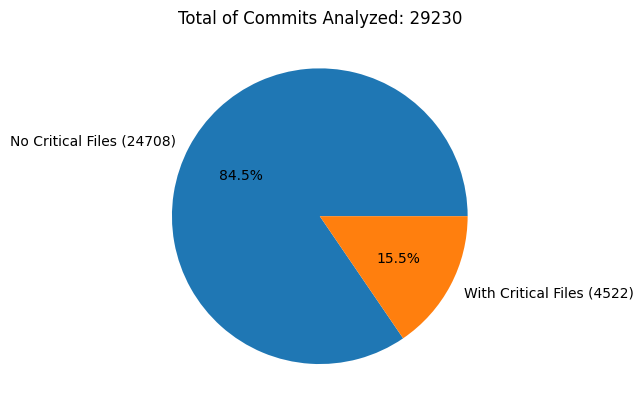

In [91]:
plt.pie([qtd_commits_no_critical_files, qtd_commits_with_critical_files], labels=[f"No Critical Files ({qtd_commits_no_critical_files})", f"With Critical Files ({qtd_commits_with_critical_files})"], autopct="%1.1f%%")
plt.title(f"Total of Commits Analyzed: {my_qtd_commits_to_analyze}")
plt.show()

In [92]:
MESSAGE_COMMIT = 0
CRITICAL_FILES_COMMIT = 1
DATE_COMMIT = 2
LINES_COMMIT = 3
FILES_COMMIT = 4
DICT_DIFF_COMMIT = 5
MODIFIED_FILES_COMMIT = 6
DICT_MODIFIED_FILES_COMMIT = 7

l_commits_aux, l_msg_aux, l_critical_files_aux, l_date_aux, l_lines_aux, l_files_commit_aux, l_diff_commit_aux, l_modified_files_aux, l_dict_modified_files = [], [], [], [], [], [], [], [], []

dict_commits_to_analyse = commits_to_analyze[0]
for k, v in dict_commits_to_analyse.items():
  l_commits_aux.append(k)
  l_msg_aux.append(v[MESSAGE_COMMIT])
  l_critical_files_aux.append(v[CRITICAL_FILES_COMMIT])
  l_date_aux.append(v[DATE_COMMIT])
  l_lines_aux.append(v[LINES_COMMIT])
  l_files_commit_aux.append(v[FILES_COMMIT])
  l_diff_commit_aux.append(v[DICT_DIFF_COMMIT])
  l_modified_files_aux.append(v[MODIFIED_FILES_COMMIT])
  l_dict_modified_files.append(v[DICT_MODIFIED_FILES_COMMIT])

dict_commits_to_analyze_aux = {
	'commits':l_commits_aux,
	'msg': l_msg_aux,
	'critical_files': l_critical_files_aux,
  'data': l_date_aux,
	'lines': l_lines_aux,
  'files': l_files_commit_aux,
	'diff_commit': l_diff_commit_aux,
	'modified_files': l_modified_files_aux,
	'dict_modified_files': l_dict_modified_files
}

df_commits_to_analyze_aux = pd.DataFrame(dict_commits_to_analyze_aux)
df_commits_to_analyze_aux.head()

,commits,msg,critical_files,data,lines,files,diff_commit,modified_files,dict_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...",2/3/2009,74502,344,"[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
1,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,Add build script and make sure it works\n\ngit...,[StorageService.java],2/3/2009,156,4,"[{'StorageService.java': '@@ -70,11 +70,6 @@ i...","[build.xml, StorageService.java, DBTest.java, ...","[@@ -0,0 +1,133 @@\n+<?xml version=""1.0"" encod..."
2,5bea7e1772e9fd042b10abebb1e0c78579942b26,Removed references to JDK7 specific things.\n\...,[ColumnFamilyStore.java],20/3/2009,82,2,"[{'ColumnFamilyStore.java': '@@ -20,7 +20,6 @@...","[ColumnFamilyStore.java, Table.java]","[@@ -20,7 +20,6 @@ package org.apache.cassandr..."
3,f4f3ca50d84e165a909dca5608babb32df199f44,rename serializer2 -> serializerWithIndexers\n...,[ColumnFamilyStore.java],27/3/2009,26,4,"[{'ColumnFamilyStore.java': '@@ -22,10 +22,7 @...","[ColumnFamily.java, ColumnFamilyStore.java, Me...","[@@ -70,7 +70,7 @@ public final class ColumnFa..."
4,39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3,add SuperColumn support to forceFlush. split ...,[ColumnFamilyStore.java],27/3/2009,89,5,"[{'ColumnFamilyStore.java': '@@ -395,11 +395,1...","[ColumnFamilyStore.java, HintedHandOffManager....","[@@ -395,11 +395,11 @@ public class ColumnFami..."


In [93]:
list_comits_with_critical_files = df_commits_to_analyze_aux.commits.to_list()
print('Commits com Arquivos Críticos (by ATDCodeAnalyzer)')
print(f'{len(list_comits_with_critical_files)}, {list_comits_with_critical_files}')

Commits com Arquivos Críticos (by ATDCodeAnalyzer)
4522, ['1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3', '5bea7e1772e9fd042b10abebb1e0c78579942b26', 'f4f3ca50d84e165a909dca5608babb32df199f44', '39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3', 'b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d', 'ce8a73f2be0406f954f39aa6f6e20863e99e5461', '66dee7aaab26556561614ab056469ade85de5ebd', 'a996c8214baa4fa886071a24b8058ed1ca284686', '4cff66a0eebd138271f3fa5f23fae3df07a7adf7', '20e081f2901384f0786a56fb21a181033aa8e839', '8ce795a0a98cf18444af4c1c1528e6a12caf1320', 'dd61d5119d951d94da28256e5482d580a0685030', 'bf684eea956dbbbf7a35ef3deca8b4462b139136', '4c194aa8d14cc8b473939d3496cd576c4cb397e7', '76f33027535a192ab2d76ac1f01a5a8829c845af', '1866e3802bb16dd582cf5a95bc41bb13e808a0ba', '964dd9bb57230e1973aaede17c520ede1453a210', '52062900caf861e237355c297709976036c70404', '1cc4294d349e4d24c8a0894e3b4748d5f3798f00', 'bd884e4d986ebfa5568a431abc55813a6a903bb5', '2f8268cd099ce32a8

In [94]:
print('Convert list_comits_with_critical_files para um conjunto de commits')
set_comits_with_critical_files = set(list_comits_with_critical_files)

Convert list_comits_with_critical_files para um conjunto de commits


## 5.3 Commits com SATD Keywords e com Arquivos críticos

Faz a intersecção entre commits com SATD keywords e commits com arquivos críticos

In [96]:
set_commits_with_satd_keywords_and_critical_files = set_comits_with_critical_files.intersection(set_list_commit_with_satd_keywords)
list_commits_with_satd_keywords_and_critical_files = list(set_commits_with_satd_keywords_and_critical_files)

In [97]:
df_commits_with_satd_keywords1 = df_commit_diffs_aux[df_commit_diffs_aux['commits'].isin(list_commits_with_satd_keywords_and_critical_files)]
df_commits_with_satd_keywords1

,commits,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,"[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
5,66dee7aaab26556561614ab056469ade85de5ebd,"[TODO, exception, TODO, exception]",[\t\t\t// TODO: throw a thrift exception if we...
6,a996c8214baa4fa886071a24b8058ed1ca284686,"[output, TODO, clean, test, TODO, test, TODO, ...","[ /* map output directory */, /..."
7,20e081f2901384f0786a56fb21a181033aa8e839,"[TODO, TODO]",[ // TODO this is broken because SST/Se...
...,...,...,...
4178,9c796dfb272daa3ce57a2dc5cbeadd9273e1ac72,[test],[ * Unit tests for {@link ColumnFamilyStore} w...
4193,20d80118ac02d853d501e3f5c24a63a12d4010f5,"[exception, not thread safe, exception]",[ /** Should throw exception if null client...
4197,d16e8d3653dce8ed767a040c06dbaabc47a9b474,"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...
4198,b9586501a6b6cdfe465302448018785652c9b966,[update],[ * Internode legacy SSL storage port certific...


In [98]:
df_commits_with_satd_keywords2 = df_commits_to_analyze_aux[df_commits_to_analyze_aux['commits'].isin(list_commits_with_satd_keywords_and_critical_files)]
df_commits_with_satd_keywords2

,commits,msg,critical_files,data,lines,files,diff_commit,modified_files,dict_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...",2/3/2009,74502,344,"[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
5,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,[ColumnFamilyStore.java],27/3/2009,997,11,"[{'ColumnFamilyStore.java': '@@ -614,17 +614,6...","[AbstractColumnFactory.java, Column.java, Colu...","[@@ -31,13 +31,13 @@ import java.util.StringTo..."
7,66dee7aaab26556561614ab056469ade85de5ebd,finish remove support. Split CFS.resolve() in...,"[ColumnFamilyStore.java, StorageProxy.java]",27/3/2009,536,8,"[{'ColumnFamilyStore.java': '@@ -18,15 +18,27 ...","[ColumnFamilyStore.java, HintedHandOffManager....","[@@ -18,15 +18,27 @@\n \r\n package org.apache..."
8,a996c8214baa4fa886071a24b8058ed1ca284686,test support. this requires some refactoring ...,"[DatabaseDescriptor.java, StorageService.java]",27/3/2009,1356,26,"[{'DatabaseDescriptor.java': '@@ -25,6 +25,8 @...","[build.xml, DatabaseDescriptor.java, BinaryMem...","[@@ -8,6 +8,8 @@\n <property name=""build.l..."
10,20e081f2901384f0786a56fb21a181033aa8e839,consolidates partition behavior in IPartitione...,"[ColumnFamilyStore.java, StorageService.java]",27/3/2009,1263,18,"[{'ColumnFamilyStore.java': '@@ -1269,39 +1269...","[ColumnFamilyStore.java, FileStruct.java, Memt...","[@@ -1269,39 +1269,10 @@ public class ColumnFa..."
...,...,...,...,...,...,...,...,...,...
4512,9c796dfb272daa3ce57a2dc5cbeadd9273e1ac72,Skip ColumnFamilyStore#topPartitions initializ...,[ColumnFamilyStore.java],1/8/2023,98,3,"[{'ColumnFamilyStore.java': '@@ -549,7 +549,7 ...","[CHANGES.txt, ColumnFamilyStore.java, ColumnFa...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Skip ColumnFamil..."
4518,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,[Config.java],19/9/2023,289,11,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
4519,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,[CompactionManager.java],25/9/2023,724,18,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
4520,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,[MessagingService.java],25/9/2023,237,13,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [99]:
df_commits_with_satd_keywords_with_critical_files = df_commits_with_satd_keywords1.merge(df_commits_with_satd_keywords2, on='commits', how='outer')

In [100]:
df_commits_with_satd_keywords_with_critical_files.columns

Index(['commits', 'keywords', 'comments', 'msg', 'critical_files', 'data',
       'lines', 'files', 'diff_commit', 'modified_files',
       'dict_modified_files'],
      dtype='object')

In [101]:
colunas_ok = ['commits', 'data', 'msg', 'lines', 'files', 'critical_files', 'keywords', 'comments',
       'diff_commit', 'modified_files','dict_modified_files']

df_commits_with_satd_keywords_with_critical_files = df_commits_with_satd_keywords_with_critical_files[colunas_ok]
df_commits_with_satd_keywords_with_critical_files

,commits,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,2/3/2009,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...,"[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
1,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,27/3/2009,add deletion marker support to Column (boolean...,997,11,[ColumnFamilyStore.java],"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...,"[{'ColumnFamilyStore.java': '@@ -614,17 +614,6...","[AbstractColumnFactory.java, Column.java, Colu...","[@@ -31,13 +31,13 @@ import java.util.StringTo..."
2,66dee7aaab26556561614ab056469ade85de5ebd,27/3/2009,finish remove support. Split CFS.resolve() in...,536,8,"[ColumnFamilyStore.java, StorageProxy.java]","[TODO, exception, TODO, exception]",[\t\t\t// TODO: throw a thrift exception if we...,"[{'ColumnFamilyStore.java': '@@ -18,15 +18,27 ...","[ColumnFamilyStore.java, HintedHandOffManager....","[@@ -18,15 +18,27 @@\n \r\n package org.apache..."
3,a996c8214baa4fa886071a24b8058ed1ca284686,27/3/2009,test support. this requires some refactoring ...,1356,26,"[DatabaseDescriptor.java, StorageService.java]","[output, TODO, clean, test, TODO, test, TODO, ...","[ /* map output directory */, /...","[{'DatabaseDescriptor.java': '@@ -25,6 +25,8 @...","[build.xml, DatabaseDescriptor.java, BinaryMem...","[@@ -8,6 +8,8 @@\n <property name=""build.l..."
4,20e081f2901384f0786a56fb21a181033aa8e839,27/3/2009,consolidates partition behavior in IPartitione...,1263,18,"[ColumnFamilyStore.java, StorageService.java]","[TODO, TODO]",[ // TODO this is broken because SST/Se...,"[{'ColumnFamilyStore.java': '@@ -1269,39 +1269...","[ColumnFamilyStore.java, FileStruct.java, Memt...","[@@ -1269,39 +1269,10 @@ public class ColumnFa..."
...,...,...,...,...,...,...,...,...,...,...,...
1683,9c796dfb272daa3ce57a2dc5cbeadd9273e1ac72,1/8/2023,Skip ColumnFamilyStore#topPartitions initializ...,98,3,[ColumnFamilyStore.java],[test],[ * Unit tests for {@link ColumnFamilyStore} w...,"[{'ColumnFamilyStore.java': '@@ -549,7 +549,7 ...","[CHANGES.txt, ColumnFamilyStore.java, ColumnFa...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Skip ColumnFamil..."
1684,20d80118ac02d853d501e3f5c24a63a12d4010f5,19/9/2023,Add the ability to disable bulk loading of SST...,289,11,[Config.java],"[exception, not thread safe, exception]",[ /** Should throw exception if null client...,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
1685,d16e8d3653dce8ed767a040c06dbaabc47a9b474,25/9/2023,Do not create sstable files before registering...,724,18,[CompactionManager.java],"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
1686,b9586501a6b6cdfe465302448018785652c9b966,25/9/2023,Internode legacy SSL storage port certificate ...,237,13,[MessagingService.java],[update],[ * Internode legacy SSL storage port certific...,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [106]:
qtd_commits_with_satd_and_critical_files = len(df_commits_with_satd_keywords_with_critical_files.commits.to_list())
qtd_commits_no_satd_no_critical_files = my_qtd_commits_to_analyze - qtd_commits_with_satd_and_critical_files

# Dos x commits com arquivos criticos quantos tem SATD?
print(f'Total de commits analisados: {my_qtd_commits_to_analyze}')
print(f'Commits que possuem pelo menos um arquivo crítico: {qtd_commits_with_critical_files}')
print(f'Qtd de commits sem SATD e sem arquivos críticos: {qtd_commits_no_satd_no_critical_files}')
print(f'Qtd de commits com SATD e arquivos críticos: {qtd_commits_with_satd_and_critical_files}')

Total de commits analisados: 29230
Commits que possuem pelo menos um arquivo crítico: 4522
Qtd de commits sem SATD e sem arquivos críticos: 27542
Qtd de commits com SATD e arquivos críticos: 1688


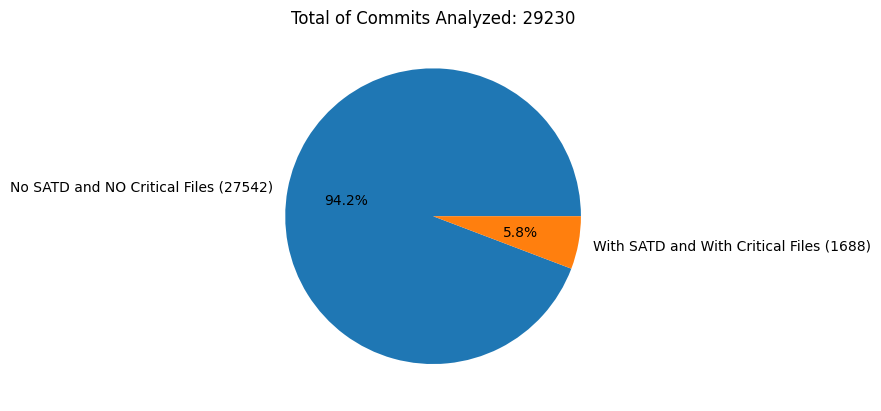

In [108]:
plt.pie([qtd_commits_no_satd_no_critical_files, qtd_commits_with_satd_and_critical_files], labels=[f"No SATD and NO Critical Files ({qtd_commits_no_satd_no_critical_files})", f"With SATD and With Critical Files ({qtd_commits_with_satd_and_critical_files})"], autopct="%1.1f%%")
plt.title(f"Total of Commits Analyzed: {my_qtd_commits_to_analyze}")
plt.show()

In [102]:
print('Salva o dataframe de df_commits_with_satd_keywords_with_critical_files em uma planilha excel')
df_commits_with_satd_keywords_with_critical_files.to_excel('commits_with_satd_keywords_with_critical_files.xlsx')

Salva o dataframe de df_commits_with_satd_keywords_with_critical_files em uma planilha excel


In [103]:
!ls -liath *.xlsx

4464105 -rw-r--r-- 1 root root 8.3M Oct  4 15:46 commits_with_satd_keywords_with_critical_files.xlsx


# 6. Analyzes Jira issues

## 6.1 Configures the instance, project and date range

In [121]:
# Initialize the Jira connection
print('Initialize the Jira connection')
jira = JIRA(JIRA_SERVER, basic_auth=(username, password))

# Create a JiraUtils instance
print('Create a JiraUtils instance')
jira_utils = JiraUtils('CASSANDRA', jira)

# Define date intervals
#start_date = datetime(2009, 3, 2, 0, 0, 0)
#end_date = datetime(2023, 10, 4, 0, 0, 0)

date1 = (2009, 3, 2)
date2 = (2023, 10, 4)
distance = 120
print('Define date intervals')
print(f'From: {str(date1)} to: {date2}, by: {distance} days of distance.')

Initialize the Jira connection
Create a JiraUtils instance
Define date intervals
From: (2009, 3, 2) to: (2023, 10, 4), by: 120 days of distance.


## 6.2 Retrieves all blocks of issues in range of dates

In [116]:
# Fetch issues using date intervals
print('Fetch issues using date intervals')
block_of_issues = jira_utils.get_list_of_block_issues_by_dates(date1, date2, distance)

Fetch issues using date intervals
Aguarde...


Progress Message Analysis:   2%|▏         | 1/45 [00:03<02:23,  3.26s/it]

Range: project=CASSANDRA and created>="2009/03/02" and created<="2009/06/29", qtd issues: 263


Progress Message Analysis:   4%|▍         | 2/45 [00:06<02:22,  3.32s/it]

Range: project=CASSANDRA and created>="2009/06/30" and created<="2009/10/27", qtd issues: 251


Progress Message Analysis:   7%|▋         | 3/45 [00:10<02:26,  3.50s/it]

Range: project=CASSANDRA and created>="2009/10/28" and created<="2010/02/24", qtd issues: 310


Progress Message Analysis:   9%|▉         | 4/45 [00:15<02:49,  4.14s/it]

Range: project=CASSANDRA and created>="2010/02/25" and created<="2010/06/24", qtd issues: 388


Progress Message Analysis:  11%|█         | 5/45 [00:21<03:13,  4.84s/it]

Range: project=CASSANDRA and created>="2010/06/25" and created<="2010/10/22", qtd issues: 419


Progress Message Analysis:  13%|█▎        | 6/45 [00:28<03:35,  5.52s/it]

Range: project=CASSANDRA and created>="2010/10/23" and created<="2011/02/19", qtd issues: 545


Progress Message Analysis:  16%|█▌        | 7/45 [00:35<03:50,  6.07s/it]

Range: project=CASSANDRA and created>="2011/02/20" and created<="2011/06/19", qtd issues: 593


Progress Message Analysis:  18%|█▊        | 8/45 [00:42<03:59,  6.48s/it]

Range: project=CASSANDRA and created>="2011/06/20" and created<="2011/10/17", qtd issues: 573


Progress Message Analysis:  20%|██        | 9/45 [00:49<03:50,  6.40s/it]

Range: project=CASSANDRA and created>="2011/10/18" and created<="2012/02/14", qtd issues: 532


Progress Message Analysis:  22%|██▏       | 10/45 [00:54<03:31,  6.03s/it]

Range: project=CASSANDRA and created>="2012/02/15" and created<="2012/06/13", qtd issues: 423


Progress Message Analysis:  24%|██▍       | 11/45 [00:59<03:18,  5.85s/it]

Range: project=CASSANDRA and created>="2012/06/14" and created<="2012/10/11", qtd issues: 441


Progress Message Analysis:  27%|██▋       | 12/45 [01:06<03:16,  5.96s/it]

Range: project=CASSANDRA and created>="2012/10/12" and created<="2013/02/08", qtd issues: 433


Progress Message Analysis:  29%|██▉       | 13/45 [01:10<03:00,  5.63s/it]

Range: project=CASSANDRA and created>="2013/02/09" and created<="2013/06/08", qtd issues: 386


Progress Message Analysis:  31%|███       | 14/45 [01:16<02:58,  5.74s/it]

Range: project=CASSANDRA and created>="2013/06/09" and created<="2013/10/06", qtd issues: 522


Progress Message Analysis:  33%|███▎      | 15/45 [01:23<03:01,  6.04s/it]

Range: project=CASSANDRA and created>="2013/10/07" and created<="2014/02/03", qtd issues: 492


Progress Message Analysis:  36%|███▌      | 16/45 [01:33<03:27,  7.14s/it]

Range: project=CASSANDRA and created>="2014/02/04" and created<="2014/06/03", qtd issues: 690


Progress Message Analysis:  38%|███▊      | 17/45 [01:41<03:32,  7.58s/it]

Range: project=CASSANDRA and created>="2014/06/04" and created<="2014/10/01", qtd issues: 680


Progress Message Analysis:  40%|████      | 18/45 [01:50<03:30,  7.80s/it]

Range: project=CASSANDRA and created>="2014/10/02" and created<="2015/01/29", qtd issues: 655


Progress Message Analysis:  42%|████▏     | 19/45 [02:02<03:54,  9.00s/it]

Range: project=CASSANDRA and created>="2015/01/30" and created<="2015/05/29", qtd issues: 802


Progress Message Analysis:  44%|████▍     | 20/45 [02:13<04:03,  9.72s/it]

Range: project=CASSANDRA and created>="2015/05/30" and created<="2015/09/26", qtd issues: 875


Progress Message Analysis:  47%|████▋     | 21/45 [02:21<03:42,  9.27s/it]

Range: project=CASSANDRA and created>="2015/09/27" and created<="2016/01/24", qtd issues: 659


Progress Message Analysis:  49%|████▉     | 22/45 [02:30<03:27,  9.04s/it]

Range: project=CASSANDRA and created>="2016/01/25" and created<="2016/05/23", qtd issues: 769


Progress Message Analysis:  51%|█████     | 23/45 [02:40<03:30,  9.55s/it]

Range: project=CASSANDRA and created>="2016/05/24" and created<="2016/09/20", qtd issues: 787


Progress Message Analysis:  53%|█████▎    | 24/45 [02:46<02:54,  8.32s/it]

Range: project=CASSANDRA and created>="2016/09/21" and created<="2017/01/18", qtd issues: 453


Progress Message Analysis:  56%|█████▌    | 25/45 [02:50<02:23,  7.16s/it]

Range: project=CASSANDRA and created>="2017/01/19" and created<="2017/05/18", qtd issues: 403


Progress Message Analysis:  58%|█████▊    | 26/45 [02:54<01:57,  6.17s/it]

Range: project=CASSANDRA and created>="2017/05/19" and created<="2017/09/15", qtd issues: 338


Progress Message Analysis:  60%|██████    | 27/45 [02:58<01:36,  5.36s/it]

Range: project=CASSANDRA and created>="2017/09/16" and created<="2018/01/13", qtd issues: 282


Progress Message Analysis:  62%|██████▏   | 28/45 [03:01<01:20,  4.73s/it]

Range: project=CASSANDRA and created>="2018/01/14" and created<="2018/05/13", qtd issues: 277


Progress Message Analysis:  64%|██████▍   | 29/45 [03:04<01:07,  4.21s/it]

Range: project=CASSANDRA and created>="2018/05/14" and created<="2018/09/10", qtd issues: 265


Progress Message Analysis:  67%|██████▋   | 30/45 [03:07<00:56,  3.77s/it]

Range: project=CASSANDRA and created>="2018/09/11" and created<="2019/01/08", qtd issues: 250


Progress Message Analysis:  69%|██████▉   | 31/45 [03:08<00:43,  3.11s/it]

Range: project=CASSANDRA and created>="2019/01/09" and created<="2019/05/08", qtd issues: 143


Progress Message Analysis:  71%|███████   | 32/45 [03:10<00:37,  2.86s/it]

Range: project=CASSANDRA and created>="2019/05/09" and created<="2019/09/05", qtd issues: 177


Progress Message Analysis:  73%|███████▎  | 33/45 [03:12<00:30,  2.56s/it]

Range: project=CASSANDRA and created>="2019/09/06" and created<="2020/01/03", qtd issues: 164


Progress Message Analysis:  76%|███████▌  | 34/45 [03:16<00:31,  2.90s/it]

Range: project=CASSANDRA and created>="2020/01/04" and created<="2020/05/02", qtd issues: 306


Progress Message Analysis:  78%|███████▊  | 35/45 [03:22<00:37,  3.80s/it]

Range: project=CASSANDRA and created>="2020/05/03" and created<="2020/08/30", qtd issues: 300


Progress Message Analysis:  80%|████████  | 36/45 [03:26<00:34,  3.84s/it]

Range: project=CASSANDRA and created>="2020/08/31" and created<="2020/12/28", qtd issues: 284


Progress Message Analysis:  82%|████████▏ | 37/45 [03:29<00:29,  3.65s/it]

Range: project=CASSANDRA and created>="2020/12/29" and created<="2021/04/27", qtd issues: 262


Progress Message Analysis:  84%|████████▍ | 38/45 [03:32<00:24,  3.51s/it]

Range: project=CASSANDRA and created>="2021/04/28" and created<="2021/08/25", qtd issues: 244


Progress Message Analysis:  87%|████████▋ | 39/45 [03:37<00:23,  3.91s/it]

Range: project=CASSANDRA and created>="2021/08/26" and created<="2021/12/23", qtd issues: 342


Progress Message Analysis:  89%|████████▉ | 40/45 [03:41<00:20,  4.05s/it]

Range: project=CASSANDRA and created>="2021/12/24" and created<="2022/04/22", qtd issues: 340


Progress Message Analysis:  91%|█████████ | 41/45 [03:45<00:15,  3.81s/it]

Range: project=CASSANDRA and created>="2022/04/23" and created<="2022/08/20", qtd issues: 267


Progress Message Analysis:  93%|█████████▎| 42/45 [03:49<00:11,  3.92s/it]

Range: project=CASSANDRA and created>="2022/08/21" and created<="2022/12/18", qtd issues: 273


Progress Message Analysis:  96%|█████████▌| 43/45 [03:53<00:08,  4.07s/it]

Range: project=CASSANDRA and created>="2022/12/19" and created<="2023/04/17", qtd issues: 328


Progress Message Analysis:  98%|█████████▊| 44/45 [03:57<00:03,  3.91s/it]

Range: project=CASSANDRA and created>="2023/04/18" and created<="2023/08/15", qtd issues: 298


Progress Message Analysis: 100%|██████████| 45/45 [03:59<00:00,  5.31s/it]

Range: project=CASSANDRA and created>="2023/08/16" and created<="2023/12/13", qtd issues: 146
2023-10-04 17:00:27.142494
Tempo da consulta: 0:03:59.051409


In [117]:
# Concatenate the block of issues into a single list
print('Concatenate the block of issues into a single list')
all_issues = jira_utils.concatenate_block_of_issues(block_of_issues)

Concatenate the block of issues into a single list
Total de issues recuperados: 18630


## 6.3 Filter SATD issues

Gera uma lista de issues que possuem SATD baseado nas keywords passadas.

In [118]:
project = 'CASSANDRA'

# Fetch 'all_issues' from your Jira server

# Call the function to analyze Jira issues for SATD
satd_issues = analyze_jira_issues_for_satd(project, my_satd_keywords, all_issues)

Progress jira issues analysis: 100%|██████████| 18630/18630 [00:03<00:00, 5521.25it/s]


In [120]:
print('Mostra um fragmento dos issues com SATD')
cont = 0
for i,each in enumerate(satd_issues.get_issues()):
  print(i+1, each)
  cont += 1
  if cont == 10:
    break

Mostra um fragmento dos issues com SATD
1 Key: CASSANDRA-263, Summary: get_slice needs to support desc from last column, Type: Bug, Status: Resolved
2 Key: CASSANDRA-261, Summary: get_slice needs offset + limit, Type: Bug, Status: Resolved
3 Key: CASSANDRA-260, Summary: Unable to read all columns in a column family from the CLI, Type: Bug, Status: Resolved
4 Key: CASSANDRA-259, Summary: LRU cache for key positions, Type: New Feature, Status: Resolved
5 Key: CASSANDRA-258, Summary: Enhance describeTable to return Map of Column Family so that it can be programatically parsed, Type: Improvement, Status: Resolved
6 Key: CASSANDRA-257, Summary: Eliminate thrift warnings , Type: Improvement, Status: Resolved
7 Key: CASSANDRA-256, Summary: Improve ListenAddress in Storage-Conf, Type: Improvement, Status: Resolved
8 Key: CASSANDRA-255, Summary: Supercolumn deserialization bug, Type: Bug, Status: Resolved
9 Key: CASSANDRA-254, Summary: clean up sstable constructors, Type: Improvement, Status: R